# 🥱 LangGraph_進階反思 Agent篇

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

# Reflexion：自我反思的 AI Agent

[Reflexion](https://arxiv.org/abs/2303.11366) 是一種創新的 AI 架構，由 Shinn 等人於 2023 年提出。其核心理念是通過語言反饋和自我反思來提升 AI 的學習能力。這種方法能夠顯著提高輸出質量，但相應地也會增加執行時間。

![圖片：Reflexion 架構圖](./img/reflexion.png)


Reflexion 的三大核心組件：

1. 具備自我反思能力的執行者（Agent）
2. 任務特定的外部評估器（如程式碼編譯步驟）
3. 存儲反思(1)結果的情景記憶.

# 環境建置

## 安裝套件包

在深入反思機制之前，我們需要先搭建實驗環境。
這次會使用到 Tavily 搜尋作為工具提供 Agent 使用，可以到[此處](https://app.tavily.com/sign-in) 獲得該服務的 API Key，如果有自己偏好的搜尋服務也可以至換。

以下是所需的套件安裝命令：

In [ ]:
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet langgraph
%pip install --upgrade --quiet langchain-community
%pip install --upgrade --quiet tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.2 MB/s eta 0:00:00


我們需要設置 環境變數 OPENAI_API_KEY ，可以直接完成，如下所示：

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

> 📌 實用提示：確保所有環境變數都正確設置，這對於順利運行後續程式碼至關重要。

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [ ]:
import os
import getpass
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %Z")

os.environ["LANGCHAIN_TRACING_V2"] = "false" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph 進階 Reflection-{current_time}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## 選擇語言模型

在本教程中，我們將使用 OpenA。但您也可以選擇其他提供商，如 IAnthropic 的 Claude 模型。添加以下代碼：

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-turbo-preview")

# You could also use OpenAI or another provider
# from langchain_anthropic import ChatAnthropic

# llm = ChatAnthropic(model="claude-3-sonnet-20240229")

## 構建 Reflexion Agent 的核心：執行者（Actor）

執行者是 Reflexion 架構的核心，它能夠生成初始回應，進行自我反思，並基於反思結果改進輸出。我們將逐步構建這個複雜的組件。這個當中包含
1. 輔助工具
2. 初始回應產生器
3. 修訂器Revisor: re-respond (and reflec) based on previous reflections


### 1. 工具設置

首先，我們需要設置一個輔助工具。在這個例子中，我們使用 Tavily 搜索作為我們的資訊來源：

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

#### 2. 初始回應生成器

接下來，我們將創建初始回應生成器。這個組件負責生成初始回答並進行自我反思：

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError


class Reflection(BaseModel):
    missing: str = Field(description="對缺失內容的批評。")
    superfluous: str = Field(description="對多餘內容的批評")

class AnswerQuestion(BaseModel):
    """回答問題。提供答案、反思，並提出搜索查詢以改進答案。"""

    answer: str = Field(description="約 250 字的詳細回答。")
    reflection: Reflection = Field(description="對初始答案的反思。")
    search_queries: list[str] = Field(
        description="1-3 個搜索查詢，用於研究改進當前答案的批評。"
    )

class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: State):
        messages = state['messages']
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": messages}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                # 確保返回更新後的狀態
                return {"messages": messages + [response]}
            except ValidationError as e:
                messages = messages + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\n請仔細檢查函數架構。\n\n"
                        + self.validator.schema_json()
                        + " 請修正所有驗證錯誤後重新回應。",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        # 如果所有嘗試都失敗，仍然返回更新後的狀態
        return {"messages": messages}

In [ ]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一位專家研究員。
當前時間：{time}

1. {first_instruction}
2. 反思並批評你的答案。請嚴格批評以最大化改進空間。
3. 推薦搜索查詢以研究信息並改進你的答案。""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>反思用戶的原始問題和迄今為止採取的行動。使用 {function_name} 函數回應。</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="提供一個詳細的約 250 字答案。",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [ ]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond({"messages":[HumanMessage(content=example_question)]})

In [ ]:
import rich
rich.print(initial)

{
    'messages': [
        HumanMessage(content='Why is reflection useful in AI?'),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_wM0Y2Nzly03AzeVsZWSQklaU',
                        'function': {
                            'arguments': '{"answer":"Reflection in AI, particularly in the context of machine 
learning and artificial intelligence development, plays a crucial role in enhancing the models\' ability to learn, 
adapt, and make more informed decisions. It involves the process where AI systems analyze their actions and 
decisions to improve future performance. Here are several reasons why reflection is essential in AI:\\n\\n1. 
**Improves Learning Efficiency:** By reflecting on past actions and outcomes, AI systems can identify patterns and 
mistakes, leading to more efficient learning and adaptation to new situations.\\n2. **Error Correction:** 
Reflection allows AI to recognize errors in its decision-making process, enabling it to correct these mistakes and 
avoid repeating them in future scenarios.\\n3. **Adaptability:** Through reflection, AI systems can assess their 
strategies and adjust them according to new information or changes in the environment, enhancing their 
adaptability.\\n4. **Self-Improvement:** AI that engages in reflection can self-optimize by continuously learning 
from experiences, leading to gradual improvements in performance over time.\\n\\nIn summary, reflection is a 
fundamental aspect of AI that encourages continuous learning and improvement, making AI systems more efficient, 
adaptable, and intelligent over time.","reflection":{"missing":"The answer could have included more technical 
details on how reflection is implemented in AI systems, such as through specific algorithms or learning models that
support self-assessment and adaptation. It could also have mentioned recent research or practical examples to 
illustrate the concept further.","superfluous":"The answer might have been overly broad in describing the benefits 
of reflection in AI without delving into the specifics of how these processes are practically applied or measured. 
Detailed examples or case studies could have made the explanation more concrete.","search_queries":["reflection in 
AI techniques","examples of reflection in machine learning","latest research on AI self-assessment"]}}',
                            'name': 'AnswerQuestion'
                        },
                        'type': 'function'
                    }
                ],
                'refusal': None
            },
            response_metadata={
                'token_usage': {'completion_tokens': 373, 'prompt_tokens': 380, 'total_tokens': 753},
                'model_name': 'gpt-4-0125-preview',
                'system_fingerprint': None,
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-6e2621fb-82cc-4011-affb-2bbfb2f2d8b4-0',
            tool_calls=[
                {
                    'name': 'AnswerQuestion',
                    'args': {
                        'answer': "Reflection in AI, particularly in the context of machine learning and artificial
intelligence development, plays a crucial role in enhancing the models' ability to learn, adapt, and make more 
informed decisions. It involves the process where AI systems analyze their actions and decisions to improve future 
performance. Here are several reasons why reflection is essential in AI:\n\n1. **Improves Learning Efficiency:** By
reflecting on past actions and outcomes, AI systems can identify patterns and mistakes, leading to more efficient 
learning and adaptation to new situations.\n2. **Error Correction:** Reflection allows AI to recognize errors in 
its decision-making process, enabling it to correct these mistakes and avoid repeating them in future 
scenarios.\n3. **Adaptability:** Through refl

#### 3. 修訂器

最後，我們需要一個修訂器，它能夠根據先前的反思和新信息來改進答案：

In [ ]:
revise_instructions = """使用新信息修改你之前的答案。
    - 你應該使用之前的批評來為你的答案添加重要信息。
        - 你必須在修改後的答案中包含數字引用，以確保它可以被驗證。
        - 在答案底部添加一個"參考文獻"部分（不計入字數限制）。格式如下：
            - [1] https://example.com
            - [2] https://example.com
    - 你應該使用之前的批評來刪除答案中多餘的信息，並確保它不超過 250 字。
"""

class ReviseAnswer(AnswerQuestion):
    """修訂你對問題的原始答案。提供答案、反思、引用你的反思，最後添加搜索查詢以改進答案。"""

    references: list[str] = Field(
        description="支持你更新答案的引用。"
    )

revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [ ]:
import json

revised = revisor.respond({"messages":
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                tavily_tool.invoke(
                    {"query": initial.tool_calls[0]["args"]["reflection"]["search_queries"][0]}
                )
            ),
        ),
    ]}
)

In [ ]:
import rich
rich.print(revised)

AIMessage(
    content='',
    additional_kwargs={
        'tool_calls': [
            {
                'id': 'call_o4fEptCcZ9w9qQgsnRsMcvEP',
                'function': {
                    'arguments': '{"answer":"Reflection in AI, the process through which AI systems assess their 
performance and make adjustments, is crucial for several reasons. It enables AI systems to adapt to new 
environments and tasks efficiently, which is essential in dynamic fields like autonomous vehicles and personalized 
learning [1][2]. By analyzing past decisions, AI can identify and correct errors, enhancing reliability and 
performance. Additionally, reflective AI systems can explain their decisions, increasing transparency and trust in 
areas such as healthcare [3]. This ability also improves human-AI collaboration by enabling AI to better understand
and predict human behavior, making interactions more effective [4].\\n\\n**References**:\\n\\n- [1] 
https://www.unite.ai/ais-inner-dialogue-how-self-reflection-enhances-chatbots-and-virtual-assistants/\\n- [2] 
https://www.kent.edu/ctl/ai-use-reflection-prompts-students\\n- [3] 
https://teachingresources.stanford.edu/resources/enhancing-reflective-practices-with-ai/\\n- [4] 
https://medium.com/stanford-d-school/reflecting-with-ai-a-tool-to-develop-human-intelligence-88cec86babf","reflecti
on":{"missing":"The initial response lacked concrete examples and specific references to support the claims made 
about the importance of reflection in AI. This omission might have made the explanation seem abstract and less 
convincing to the reader.","superfluous":"The original answer was somewhat verbose and could benefit from being 
more concise. Including more direct examples or case studies would make it more engaging and 
informative.","search_queries":["examples of reflective AI in use","adaptive learning AI case studies","AI 
transparency through reflection 
techniques"],"references":["https://www.unite.ai/ais-inner-dialogue-how-self-reflection-enhances-chatbots-and-virtu
al-assistants/","https://www.kent.edu/ctl/ai-use-reflection-prompts-students","https://teachingresources.stanford.e
du/resources/enhancing-reflective-practices-with-ai/","https://medium.com/stanford-d-school/reflecting-with-ai-a-to
ol-to-develop-human-intelligence-88cec86babf"]}}',
                    'name': 'ReviseAnswer'
                },
                'type': 'function'
            }
        ],
        'refusal': None
    },
    response_metadata={
        'token_usage': {'completion_tokens': 447, 'prompt_tokens': 3545, 'total_tokens': 3992},
        'model_name': 'gpt-4-0125-preview',
        'system_fingerprint': None,
        'finish_reason': 'tool_calls',
        'logprobs': None
    },
    id='run-a4667594-5852-4482-b87f-bafed2334df8-0',
    tool_calls=[
        {
            'name': 'ReviseAnswer',
            'args': {
                'answer': 'Reflection in AI, the process through which AI systems assess their performance and make
adjustments, is crucial for several reasons. It enables AI systems to adapt to new environments and tasks 
efficiently, which is essential in dynamic fields like autonomous vehicles and personalized learning [1][2]. By 
analyzing past decisions, AI can identify and correct errors, enhancing reliability and performance. Additionally, 
reflective AI systems can explain their decisions, increasing transparency and trust in areas such as healthcare 
[3]. This ability also improves human-AI collaboration by enabling AI to better understand and predict human 
behavior, making interactions more effective [4].\n\n**References**:\n\n- [1] 
https://www.unite.ai/ais-inner-dialogue-how-self-reflection-enhances-chatbots-and-virtual-assistants/\n- [2] 
https://www.kent.edu/ctl/ai-use-reflection-prompts-students\n- [3] 
https://teachingresources.stanford.edu/resources/enhancing-reflective-practices-with-ai/\n- [4] 
https://medium.com/stanford-d-school/reflecting-with-ai-a-tool-to-develop-human-intelligen

## 建構 Graph

## 創建工具節點

為了執行工具調用，我們需要創建一個工具節點。這個節點將處理搜索查詢並返回結果：
雖然我們給大型語言模型（LLM）不同的 Schema 名稱，但我們希望它們都能路由到相同的工具。


In [ ]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

def run_queries(search_queries: list[str], **kwargs):
    """執行生成的查詢。"""
    messages = state['messages']
    last_message = messages[-1]
    if isinstance(last_message, AIMessage):
        search_queries = last_message.additional_kwargs.get('function_call', {}).get('arguments', {}).get('search_queries', [])
        results = tavily_tool.batch([{"query": query} for query in search_queries])
        return {"messages": messages + [ToolMessage(content=str(results))]}
    return {"messages": messages}


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

##構建 Reflexion 圖


現在，我們將所有組件連接起來，形成一個完整的 Reflexion 系統：

In [ ]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain.schema import BaseMessage, HumanMessage, AIMessage
import operator
from typing import Sequence, TypedDict, List

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

MAX_ITERATIONS = 1
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)
builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)

# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:
def _get_num_iterations(state: State):
    i = 0
    for m in state['messages'][::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: State) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    last_message = state['messages'][-1]
    if isinstance(last_message, AIMessage):
        return "execute_tools"
    return "revise"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

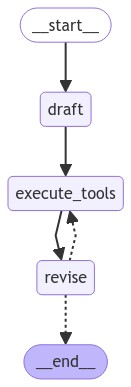

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 實際互動與測試
現在我們已經構建了完整的 Reflexion Agent，讓我們用一個實際問題來測試它：


In [ ]:
initial_state = State(messages=[HumanMessage(content="我們應該如何應對氣候危機？")])
events = graph.stream(initial_state, stream_mode="values")

print("Reflexion Agent 正在處理您的問題...\n")

for i, step in enumerate(events):
    print(f"步驟 {i + 1}:")
    print(step)
    if isinstance(step, dict) and 'messages' in step:
        last_message = step['messages'][-1]
        if not isinstance(last_message, AIMessage):
            # 如果最後一條消息不是 AIMessage，添加一個
            step['messages'].append(AIMessage(content="處理中，準備下一步操作。"))
        step['messages'][-1].pretty_print()
    else:
        print("無法顯示此步驟的結果")
        # 確保即使在這種情況下也返回一個有效的狀態
        step = {"messages": [AIMessage(content="無法處理當前步驟。")]}
    print("\n" + "="*50 + "\n")
    if i > MAX_ITERATIONS:
        print("已達到最大迭代次數，跳出循環。")
        break

Reflexion Agent 正在處理您的問題...

步驟 1:
{'messages': [HumanMessage(content='我們應該如何應對氣候危機？', id='cdc898d7-551f-4f4d-ab14-8209fcb31ac6')]}
================================== Ai Message ==================================

處理中，準備下一步操作。


步驟 2:
{'messages': [HumanMessage(content='我們應該如何應對氣候危機？', id='cdc898d7-551f-4f4d-ab14-8209fcb31ac6'), AIMessage(content='處理中，準備下一步操作。', id='0ff12149-87f1-4c3b-a4c9-7042bac0477e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uTZvYms8GTg0zOEjacnyVqKM', 'function': {'arguments': '{"answer":"應對氣候危機需要一個多管齊下的策略，涉及國際合作、政策制定、科技創新、公眾教育以及個人行為改變。首先，國際合作至關重要，因為氣候變化是一個全球性問題，需要各國共同努力。這包括遵守巴黎協定等國際協議，減少溫室氣體排放，以及投資可再生能源和其他低碳技術。\\n\\n其次，政策制定者需要制定和執行有力的政策來鼓勵減排和綠色創新，例如碳定價、補貼可再生能源、提高能效標準和限制化石燃料的使用。科技創新也是關鍵，從提高能源效率到開發新的可再生能源技術，科技進步能夠幫助我們更有效地應對氣候變化。\\n\\n公眾教育和意識提高是解決氣候危機的另一個重要方面。通過教育，人們可以了解氣候變化的原因和後果，學會如何通過日常行為減少對環境的影響。最後，每個人都需要採取行動，從減少浪費、使用公共交通到支持環保政策和企業，個人的努力也是重要的一環。","reflection":{"missing":"沒有提供具體的案例或實際措施的例子，這些可能會使讀者更容易理解和實踐這些建議。","superfluous":"答案可能過於廣泛，

```
Args:
    answer: 應對氣候危機需要一個多管齊下的策略，涉及國際合作、政策制定、科技創新、公眾教育以及個人行為改變。首先，國際合作至關重要，因為氣候變化是一個全球性問題，需要各國共同努力。這包括遵守巴黎協定等國際協議，減少溫室氣體排放，以及投資可再生能源和其他低碳技術。

其次，政策制定者需要制定和執行有力的政策來鼓勵減排和綠色創新，例如碳定價、補貼可再生能源、提高能效標準和限制化石燃料的使用。科技創新也是關鍵，從提高能源效率到開發新的可再生能源技術，科技進步能夠幫助我們更有效地應對氣候變化。

公眾教育和意識提高是解決氣候危機的另一個重要方面。通過教育，人們可以了解氣候變化的原因和後果，學會如何通過日常行為減少對環境的影響。最後，每個人都需要採取行動，從減少浪費、使用公共交通到支持環保政策和企業，個人的努力也是重要的一環。
    reflection: {'missing': '沒有提供具體的案例或實際措施的例子，這些可能會使讀者更容易理解和實踐這些建議。', 'superfluous': '答案可能過於廣泛，沒有針對特定領域或最新的科技創新進行深入探討。'}
    search_queries: ['氣候危機最新解決策略', '成功的氣候變化政策案例', '可再生能源科技創新']
```

> 提醒：會明顯感受到會的緩慢，但可以看到逐步提供的效果。

運行這段程式碼，您將看到 Reflexion Agent 如何逐步生成初始回答，進行自我反思，搜索新信息，並不斷改進其回答。這個過程展示了 AI 如何通過反思和迭代來提升其輸出質量。


## 結果

在觀察 Reflexion Agent 的輸出後，我們可以討論以下幾點：


1. 初始回答與最終回答的對比：注意初始回答和最終回答之間的差異。最終回答通常會更加全面、準確，並包含更多具體的事實和數據。
2. 反思過程的價值：觀察 Agent 是如何批評自己的初始回答，並確定需要改進的地方。這種自我批評能力是 Reflexion 架構的核心優勢。
3. 信息搜索的作用：分析 Agent 是如何利用搜索結果來補充和改進其回答的。這展示了將外部知識整合到 AI 系統中的重要性。